In [13]:
import requests, scipy
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter, get_common_distributions
from sklearn.preprocessing import StandardScaler
sns.set()

In [14]:
def get_data(url,commodity):
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['response']['data'])[::-1]
        df['value'] = pd.to_numeric(df['value'])
        df = df[['period','product-name','value','units']].reset_index(drop=True)
        columns = df.columns[~df.columns.isin(['period'])]
        df.rename(columns = dict(zip(columns,columns + commodity)),inplace=True)
        df = df[df['period'] > '2010-01-01']
        return(df)
    
    else:
        print(response.status_code)

In [49]:
api_key = '4O5kSraa6cJNrQho3z4yraGpnYEyBlIgNhYSLrLo'
crude_url = "https://api.eia.gov/v2/petroleum/pri/spt/data/?frequency=daily&data[0]=value&facets[product][]=EPCWTI&end=2024-02-12&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={}".format(api_key)
gas_url = "https://api.eia.gov/v2/natural-gas/pri/fut/data/?frequency=daily&data[0]=value&facets[process][]=PS0&end=2024-02-12&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={}".format(api_key)
gasdf = get_data(gas_url,'Gas')
crudedf = get_data(crude_url,'Crude')

In [50]:
def data_clean(gasdf,crudedf):  
    df = pd.merge(crudedf,gasdf,on='period',how='inner')
    df['Crude to Gas Ratio'] = df['valueCrude']/df['valueGas']
    df = df[df['Crude to Gas Ratio'] > 0]
    df['period'] = pd.to_datetime(df['period'])
    df.replace([np.inf,-np.inf],np.nan,inplace=True)
    df.dropna(inplace=True)
    return(df)

df = data_clean(gasdf,crudedf)

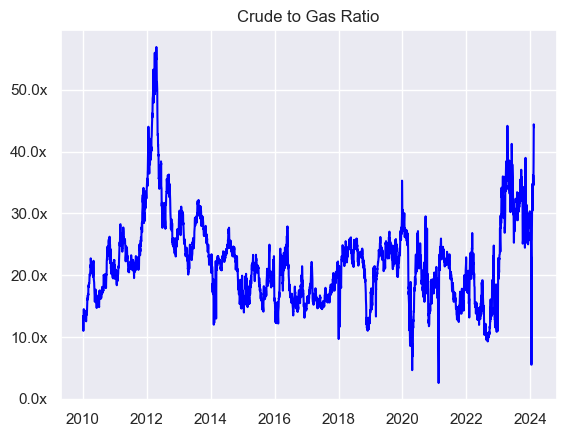

In [51]:
from matplotlib.ticker import FuncFormatter

def custom_formatter(x,pos):
    return(f"{x}x")

formatter = FuncFormatter(custom_formatter)


plt.plot(df['period'],df['Crude to Gas Ratio'],c='blue')
plt.title('Crude to Gas Ratio')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [17]:
def ad_fuller(test_series,date_range,plotchart,prefix):  
    
    result = sm.tsa.stattools.adfuller(test_series.values)

    series_std = test_series.rolling(window=365).std()
    series_mean = test_series.rolling(window=365).mean()
    
    if plotchart == True:

        plt.plot(date_range,test_series,color='blue',label= prefix + 'Crude to Gas Ratio')
        plt.plot(date_range,series_std,color='red',label='Rolling Standard Deviation')
        plt.plot(date_range,series_mean,color='black',label='Rolling Mean')
        
        if prefix =="":
            plt.legend(loc = 'upper center')
        else:
            plt.legend(loc = 'center left',bbox_to_anchor=(0,0.3))
        plt.xlabel('Date')
        plt.ylabel(prefix + 'Crude to Gas Ratio')
        plt.title("Rolling Mean and Standard Deviation")
        plt.show()
    
    print('ADF Statistic: %.4f' % result[0])
    print('p-value: %.4f' % result[1])

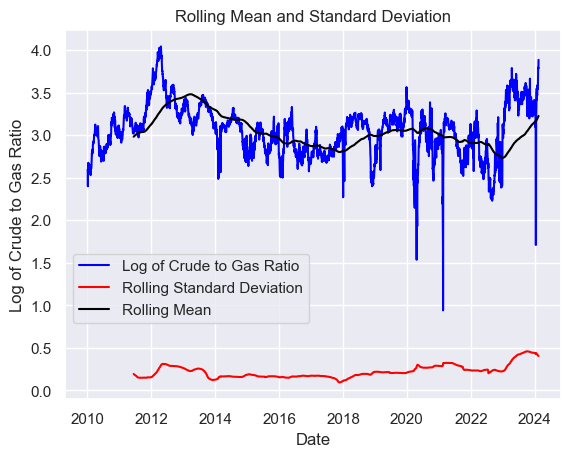

ADF Statistic: -4.5854
p-value: 0.0001


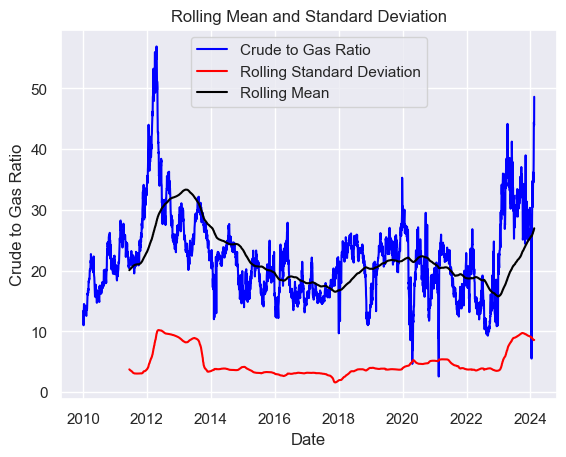

ADF Statistic: -3.4496
p-value: 0.0094


In [18]:
plotchart = True
ad_fuller(np.log(df['Crude to Gas Ratio']),df['period'],plotchart,"Log of ")
ad_fuller(df['Crude to Gas Ratio'],df['period'],plotchart,"")

In [19]:
def hurst_exponent(data,transform):
    data = np.array(data)
    lags = range(2,100)
    t = [np.sqrt(np.std(np.subtract(data[lag:], data[:-lag]))) for lag in lags]
    ply = np.polyfit(np.log(lags),np.log(t),1)
    he = ply[0] *2
    print(transform,"Hurst Exponent: %.4f" % he )

hurst_exponent(np.log(df['Crude to Gas Ratio']),"Natural Log Transform")
hurst_exponent(df['Crude to Gas Ratio'],"No Transform")


Natural Log Transform Hurst Exponent: 0.3077
No Transform Hurst Exponent: 0.3835


In [29]:

def cadf(df):
    
    x = df['valueCrude']
    y = df['valueGas']
    
    x1 = sm.add_constant(x)
    model = sm.OLS(y,x1).fit()
    
    resid = model.resid
    cadf = sm.tsa.stattools.adfuller(resid)
    plt.plot(df['period'],resid,c='blue')
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("OLS Regression Error")
    plt.title("OLS Regression Residuals from CADF Test")
    print('Regression Beta p-value: %.4f' % model.pvalues[1])
    print('CADF Statistic: %.4f' % cadf[0])
    print('p-value: %.4f' % cadf[1])


Regression Beta p-value: 0.0000
CADF Statistic: -4.8854
p-value: 0.0000


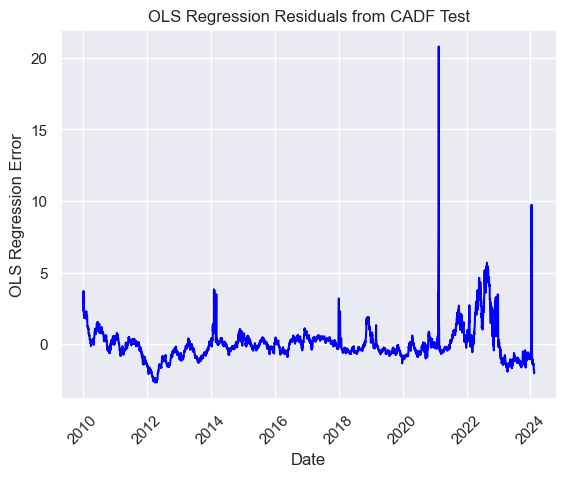

In [30]:
cadf(df)

Regression Beta p-value: 0.0000
CADF Statistic: -3.8877
p-value: 0.0021


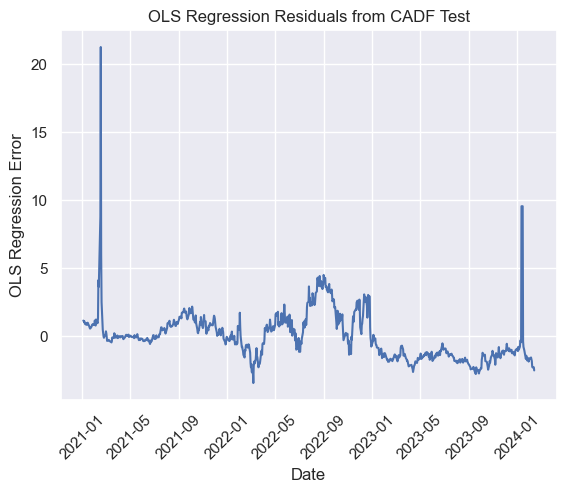

In [22]:

cadf(df[df['period'] > '2021-01-01'])

In [23]:
scaler = StandardScaler()
rawdata = np.array(np.log(df['Crude to Gas Ratio'])).reshape(-1,1)

scaler.fit(rawdata)
data = scaler.transform(rawdata)

In [24]:
def fit_dist(data,dists):
    
    f = Fitter(data,distributions=dists)
    f.fit()
    return(f)

dist = fit_dist(data,get_common_distributions())

2024-04-07 15:36:59.693 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.16656)
2024-04-07 15:36:59.698 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=2.095478)
2024-04-07 15:36:59.704 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=2.66602)
2024-04-07 15:36:59.723 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1.87045)
2024-04-07 15:36:59.739 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=1.85132)
2024-04-07 15:36:59.797 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.283762)
2024-04-07 15:37:00.431 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.169234)
2024-04-07 15:37:00.456 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expo

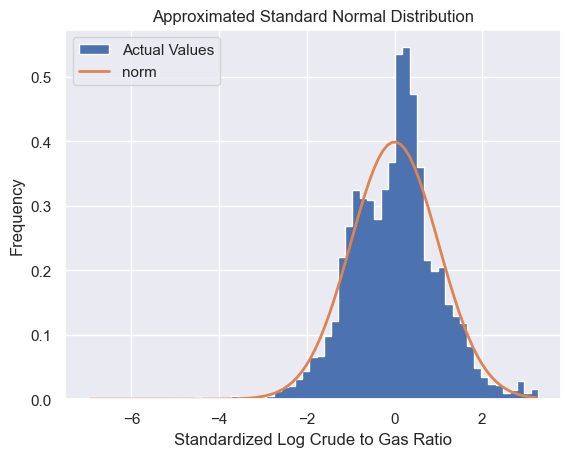

In [33]:
def show_fit(data,dist):
    
    plt.hist(data,density=True,bins='auto',histtype='stepfilled',label='Actual Values')
    dist.plot_pdf(names=list(dist.get_best(method = 'sumsquare_error').keys())[0])
    plt.title("Approximated Standard Normal Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Standardized Log Crude to Gas Ratio")
    plt.show()

show_fit(data,dist)

In [16]:
def normal_test(data):

    norm_test = scipy.stats.normaltest(data,axis=0)
    print('Statistic: %.4f' % norm_test[0])
    print('p-value: %.4f' % norm_test[1])

normal_test(data)

Statistic: 118.8667
p-value: 0.0000


In [19]:
z_score = float(scaler.transform(np.array(np.log(df.loc[df['period'] == '2024-02-12']['Crude to Gas Ratio'].iloc[0])).reshape(-1,1)))
z_score

2.4247252123225196

In [21]:
df.loc[df['period'] == '2024-02-12']['Crude to Gas Ratio'].iloc[0]

43.94318181818182

In [178]:
best_dist = dist.get_best(method='sumsquare_error')

loc = best_dist['norm']['loc']
scale = best_dist['norm']['scale']

# short_ratio = np.log(df.loc[df['period'] == '2024-02-12']['Crude to Gas Ratio'].iloc[0])
short_quantile = scipy.stats.norm.cdf(z_score,loc=loc,scale=scale)
print('Went short at', format(short_quantile,'.3%'),'percentile of historical ratio values')

Went short at 99.234% precentile of historical ratio values
